In [1]:
%load_ext autoreload
%autoreload 2

# Vanilla MCDropout

In [2]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import torch.nn as nn
from collections import OrderedDict
from torch.utils.data import TensorDataset, DataLoader

In [494]:

device = torch.device("cpu")
dim = 1
dtype = torch.double
def oracle(x, noise=0):
    # returns sin(2pi x) + epsilon with epsilon ~ N(0, 0.1)
    with torch.no_grad():
        m = torch.distributions.Normal(torch.tensor([0.0]), torch.tensor([1]))
        m = m.sample((x.size(0),))
    return torch.where(torch.logical_and(x > 0.5, x < 1.5),
                       3./5 * (torch.sin(x) * torch.cos(5 * x) * torch.cos(22 * x) * -3 * torch.sin(7 * x) * torch.cos(19 * x) * 4 * torch.sin(11 * x)),
                       (2 * np.pi * x).sin()) + noise * m

def generate_data(n=1024, nood=32):
    # generate data from U([0, 1/2] union U([1/2 + sep, 1 + sep]))
    # sep needs to be < 1.5
    with torch.no_grad():
        x = torch.zeros(n // 2, 1).uniform_(0, 0.5).to(dtype)
        x = torch.cat((x, torch.zeros(n // 2, 1).uniform_(1.5, 2)), 0).to(dtype)
        # ood_x = torch.zeros(32, 1).uniform_(0.5, 1.5)
        x_test = torch.linspace(-0.5, 2.5, 1024).view(-1, 1).to(dtype)
        ood_x = torch.zeros(nood // 4, 1).uniform_(-0.25, 0.0).to(dtype)
        ood_x = torch.cat((ood_x, torch.zeros(nood // 4, 1).uniform_(2, 2.25)), 0).to(dtype)
        ood_x = torch.cat((ood_x, torch.zeros(nood, 1).uniform_(0.5, 1.5)), 0).to(dtype)
        y = oracle(x).to(dtype)
        ood_y = oracle(ood_x).to(dtype)
        y_test_true = oracle(x_test, noise=0).to(dtype)
        return x, y, x_test, y_test_true, ood_x, ood_y

# x, y, x_test, y_test, ood_x, ood_y = generate_data(1024, 24)
x, y, x_test, y_test, ood_x, ood_y = generate_data(1024, 128)

# ood_x = cheat_remove(ood_x, (0.65, 0.7))
ood_y = oracle(ood_x)
X_train = torch.cat((x, ood_x))
Y_train = torch.cat((y, ood_y))
data = TensorDataset(X_train, Y_train)

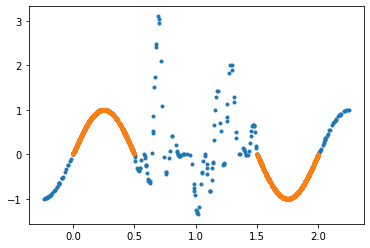

In [495]:
plt.plot(X_train, Y_train.squeeze(), '.')
plt.plot(x, y.squeeze(), '.')

In [496]:
input_dim = 1
output_dim = 1
activation_fn = nn.ReLU
loss_fn = nn.MSELoss()

In [499]:
def make_model_and_optim(lr, dropout_prob, n_hidden=32, hidden_layers=1):
    model = nn.Sequential(OrderedDict([
        ('input_layer', nn.Linear(input_dim, n_hidden)),
        ('activation1', activation_fn()),
        ('dropout1', nn.Dropout(p=dropout_prob)),
    ]))
    for i in range(hidden_layers):
        model.add_module('hidden_layer{}'.format(i + 1), nn.Linear(n_hidden, n_hidden))
        model.add_module('activation{}'.format(i + 2), activation_fn())
        model.add_module('dropout{}'.format(i + 2), nn.Dropout(p=dropout_prob))
    model.add_module('output_layer', nn.Linear(n_hidden, output_dim))
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    return model.to(dtype), optimizer

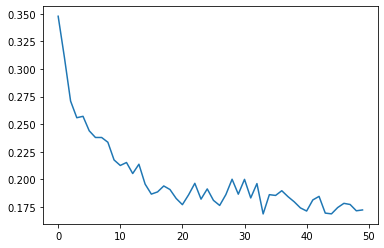

In [500]:
epochs = 50
lr = 1e-2
batch_size = 32
model, optimizer = make_model_and_optim(lr=lr, dropout_prob=0.4, hidden_layers=1)
model.train()

loader = DataLoader(data, shuffle=True, batch_size=batch_size)
losses = []
for epoch in range(epochs):
    epoch_losses = []
    for batch_id, (xi, yi) in enumerate(loader):
        optimizer.zero_grad()
        y_hat = model(xi)
        f_loss = loss_fn(y_hat, yi)
        epoch_losses.append(f_loss.item())
        f_loss.backward()
        optimizer.step()
    losses.append(np.mean(epoch_losses))
plt.plot(losses)

In [501]:
# Uncertainties
def get_dist(model, x, num_samples=10):
    model.train()
    outputs = torch.cat([model(x).unsqueeze(0) for _ in range(num_samples)])
    y_mean = outputs.mean(0)
    y_std = outputs.std(0)
    return y_mean.detach().squeeze(), y_std.detach().squeeze()

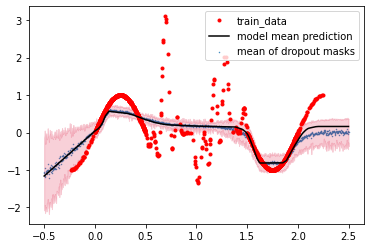

In [502]:
model.eval()
non_dropout_pred = model(x_test).detach()
Y_mean, Y_std = get_dist(model, x_test, num_samples=100)
plt.plot(X_train, Y_train, 'r.', label='train_data')
plt.scatter(x_test, Y_mean, s=.2, label='mean of dropout masks')

plt.plot(x_test, non_dropout_pred, 'k', label='model mean prediction')

plt.fill_between(x_test.squeeze(), Y_mean - Y_std, Y_mean + Y_std, color='crimson', alpha=.2)
plt.legend()

# Model with learnable dropout mask


In [503]:
from masks import DifferentiableBernoulli, ModelWithFixedDropout, ModelWithDropout

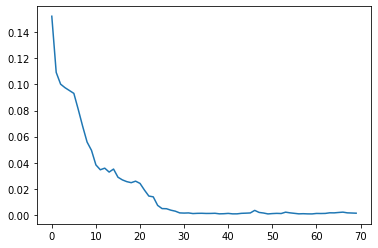

In [512]:
# model_drop = ModelWithFixedDropout().to(torch.double)
model_drop = ModelWithDropout(tau=1).to(torch.double)
epochs = 70
lr = 1e-2
batch_size = 32
optimizer = torch.optim.Adam(model_drop.parameters(), lr=lr)
model_drop.train()
data = TensorDataset(x, y)

loader = DataLoader(data, shuffle=True, batch_size=batch_size)
losses = []
for epoch in range(epochs):
    epoch_losses = []
    for batch_id, (xi, yi) in enumerate(loader):
        optimizer.zero_grad()
        y_hat = model_drop(xi)
        f_loss = loss_fn(y_hat, yi)
        epoch_losses.append(f_loss.item())
        f_loss.backward()
        optimizer.step()
    losses.append(np.mean(epoch_losses))
plt.plot(losses)

In [ ]:
# match oos-sample L2 errors 
lr = 1e-4
epochs = 100
batch_size = 64
# optimizer = torch.optim.Adam([model_drop.premask], lr=lr)
optimizer = torch.optim.Adam(model_drop.premask_networks.parameters(), lr=lr)
# data = TensorDataset(torch.cat((x[:100,:], ood_x)), torch.cat((y[:100,:], ood_y)))
data = TensorDataset(X_train, Y_train)
# data = TensorDataset(ood_x, ood_y)
loader = DataLoader(data, shuffle=True, batch_size=batch_size)
losses = []
for epoch in range(epochs):
    epoch_losses = []
    for batch_id, (xi, yi) in enumerate(loader):
        optimizer.zero_grad()
        model_drop.train()
        y_mean = model_drop(xi)
        model_drop.eval()
        y_noisy = model_drop(xi)
        pred_uncertainty = (y_mean - y_noisy) ** 2
        true_uncertainty = (yi - y_mean) ** 2
        f_loss = loss_fn(pred_uncertainty, true_uncertainty)
        epoch_losses.append(f_loss.item())
        f_loss.backward()

        optimizer.step()
    losses.append(np.mean(epoch_losses))
plt.plot(losses)

In [506]:
# Uncertainties
def get_dist_deup(model_drop, x):
    model_drop.train()
    y_mean = model_drop(x)
    model_drop.eval()
    y_noisy = model_drop(x)
    y_std = torch.abs(y_mean - y_noisy)
    return y_mean.detach().squeeze(), y_std.detach().squeeze()

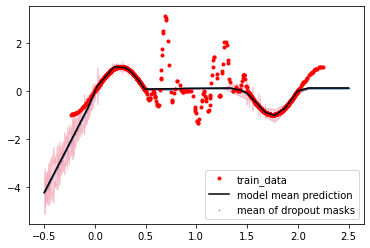

In [507]:
model_drop.train()
non_dropout_pred = model_drop(x_test).detach()
Y_mean, Y_std = get_dist_deup(model_drop, x_test)
plt.plot(X_train, Y_train, 'r.', label='train_data')
plt.scatter(x_test, Y_mean, s=.2, label='mean of dropout masks')

plt.plot(x_test, non_dropout_pred, 'k', label='model mean prediction')

plt.fill_between(x_test.squeeze(), Y_mean - Y_std, Y_mean + Y_std, color='crimson', alpha=.2)
plt.legend()

In [508]:
X = X_train # x_test
Y = Y_train # y_test

model_drop.train()
y_mean = model_drop(X)
model_drop.eval()
y_noisy = model_drop(X)
pred_uncertainty = (y_mean - y_noisy) ** 2
true_uncertainty = (Y - y_mean) ** 2

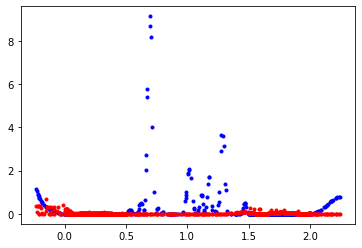

In [509]:
plt.plot(X, true_uncertainty.detach(), 'b.')
plt.plot(X, pred_uncertainty.detach(), 'r.')


In [510]:
((pred_uncertainty - true_uncertainty) ** 2).mean()

tensor(0.3408, dtype=torch.float64, grad_fn=<MeanBackward0>)

In [487]:
torch.sigmoid(model_drop.premask_networks[1](x)).mean(axis=0)

tensor([7.7573e-01, 2.2702e-02, 3.5679e-03, 4.8873e-01, 1.0000e+00, 9.9995e-01,
        8.2979e-04, 1.2490e-01, 7.1295e-01, 4.8972e-01, 1.3276e-01, 3.0896e-01,
        3.0381e-01, 8.1384e-01, 9.9980e-01, 3.4207e-02, 2.8798e-01, 4.9359e-01,
        6.6991e-01, 9.6264e-01, 7.2332e-01, 9.7388e-01, 1.0000e+00, 9.9999e-01,
        9.9983e-01, 9.9955e-01, 9.8376e-03, 4.9111e-01, 1.0000e+00, 8.9554e-01,
        5.1480e-01, 9.9999e-01], dtype=torch.float64, grad_fn=<MeanBackward1>)

In [488]:
torch.sigmoid(model_drop.premask_networks[1](ood_x)).mean(axis=0)

tensor([8.4682e-01, 1.7727e-02, 2.1795e-03, 2.1332e-01, 1.0000e+00, 9.9995e-01,
        8.1465e-04, 1.2865e-01, 8.4286e-01, 2.1318e-01, 8.6327e-02, 3.1830e-01,
        2.2192e-01, 7.9878e-01, 9.9994e-01, 2.6720e-02, 2.8587e-01, 2.3286e-01,
        6.6236e-01, 9.8049e-01, 7.2223e-01, 9.8139e-01, 1.0000e+00, 9.9999e-01,
        9.9983e-01, 9.9969e-01, 8.1442e-03, 2.3848e-01, 1.0000e+00, 8.9210e-01,
        5.8448e-01, 9.9999e-01], dtype=torch.float64, grad_fn=<MeanBackward1>)

In [489]:
torch.sigmoid(model_drop.premask_networks[1](x_test)).mean(axis=0)

tensor([8.0042e-01, 2.1489e-02, 3.4548e-03, 3.5309e-01, 1.0000e+00, 9.9995e-01,
        7.1868e-04, 1.2622e-01, 7.5571e-01, 3.5314e-01, 1.3071e-01, 3.2178e-01,
        2.8226e-01, 8.0651e-01, 9.9989e-01, 3.9622e-02, 2.7716e-01, 3.6720e-01,
        6.7251e-01, 9.7281e-01, 7.1822e-01, 9.7571e-01, 1.0000e+00, 9.9999e-01,
        9.9983e-01, 9.9956e-01, 9.6180e-03, 3.7106e-01, 1.0000e+00, 8.9569e-01,
        5.3389e-01, 9.9999e-01], dtype=torch.float64, grad_fn=<MeanBackward1>)

In [490]:
model_drop.eval()
torch.cat([model_drop(x) for _ in range(10)], 1).std(1)

tensor([0.0103, 0.0172, 0.0168,  ..., 0.0333, 0.0267, 0.0062],
       dtype=torch.float64, grad_fn=<StdBackward1>)

In [492]:
torch.cat([model_drop(ood_x) for _ in range(10)], 1).std(1)

tensor([0.0040, 0.0040, 0.0000, 0.0000, 0.0000, 0.0150, 0.0511, 0.0481, 0.0021,
        0.0000, 0.0411, 0.0000, 0.0000, 0.0121, 0.1297, 0.0696, 0.0053, 0.0072,
        0.0086, 0.0042, 0.1575, 0.0059, 0.0049, 0.1085, 0.0973, 0.0074, 0.0049,
        0.0000, 0.0000, 0.0064, 0.0020, 0.0093, 0.0394, 0.0014, 0.0230, 0.0000],
       dtype=torch.float64, grad_fn=<StdBackward1>)